# Задача
Нейронная сеть: обучить пример с Keras на других данных — по-другому проинициализировать генератор случайных чисел, взять неслучайные точки (регулярные, например), посмотреть (и показать =)), как изменится результат.

In [1]:
import os
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense, Input
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def saturate(v):
    return min(1, max(0, v))

import matplotlib.pyplot as plt
def plot_from_model(filename, smooth=False):
    if(os.path.isfile(filename)):
        model = load_model(filename)
    else:
        print(f"No file found:{filename}")
        return
    %matplotlib inline
    plt.axis('equal')
    plt.rcParams["figure.figsize"] = [16,9]
    
    c = np.r_[-2:2:0.1]
    # https://stackoverflow.com/a/11144716/539470 =)
    XY = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])
    Z = model.predict(XY)
    
    
    if smooth:
        for (x, y), z in zip(XY, Z):
            plt.scatter(x, y, color=[(1, 1-saturate(z[0]), 1-saturate(z[0]))])
    else:
        for (x, y), z in zip(XY, Z):
            plt.scatter(x, y, c='red' if z[0] >= 0.5 else 'green')
    plt.show() 

In [3]:
def inCircle(a):
    return 1 if a[0]**2+a[1]**2<=1 else 0

def teach_model(X,iters,filename):
    Y=[inCircle(a) for a in X]
    l0 = Input(shape=(2,))
    l1 = Dense(6, activation='sigmoid', use_bias=True)(l0)
    l2 = Dense(1, activation='sigmoid', use_bias=False)(l1)

    model = Model(input=l0, output=l2)

    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['accuracy']
    )
    model.fit(
            X, Y,
            epochs=10000,
            verbose=False
        )
    model.save(filename)

Для начала посмотрим, что будет, если в оригинальной программе менять сиды генератора случайных чисел. Следующие 5 графиков - предсказания моделей с сидами 1...5.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


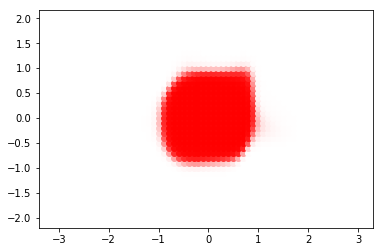

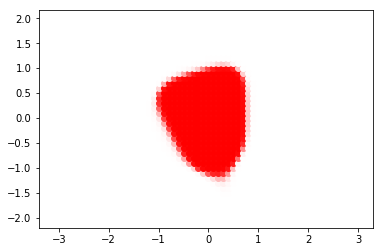

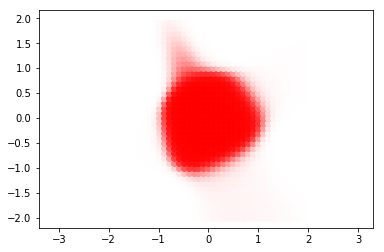

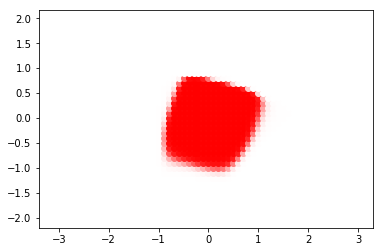

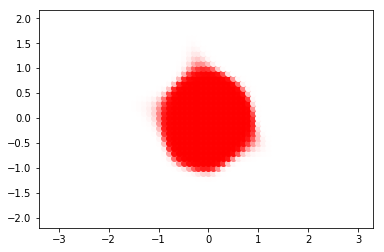

In [4]:
models =['smart_duckling.h5','smart_duckling_2.h5','smart_duckling_3.h5','smart_duckling_4.h5','smart_duckling_5.h5']
for filename in models:
    plot_from_model(filename,smooth=True)

Видим, что всё плохо - если не повезёт с расположением случайных точек, то есть области, где модель предсказывает сильно неправильно.

Попробуем исправить это - вместо случайных точек возьмём в качестве входа сетку [-2:2:0.2] - всего 400 точек.

In [5]:
#making a grid

c = np.r_[-2:2:0.2]

# https://stackoverflow.com/a/11144716/539470 =)
grid = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])
print(len(c)**2)
grid[0]

400


array([-2., -2.])

Обучим модель на ней и построим график результата:

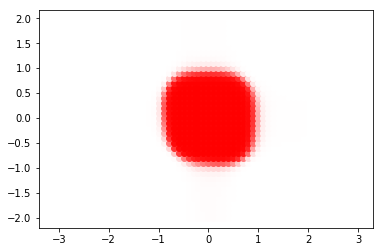

In [6]:
#Рекомендуется убедиться, что файлы модели скачаны и лежат вместе с блокнотом -
#- иначе обучение этой и последующих моделей займёт минут по 10
filename = 'smart_duckling_grid.h5'
if(not os.path.isfile(filename)):
    teach_model(grid,10000,filename)
plot_from_model(filename,smooth=True)

Уже лучше, но немного угловато - не помешало бы уточнить границу.
Давайте добавим во входные данные две окружности радиусов 0.95 и 1.05. Будем брать, скажем, по 100 точек на каждую.

In [7]:
from math import pi, sin,cos
#making two bounding circles close to the original
bounding = np.zeros((200,2))
for i in range(100):
    bounding[i][0]=0.95*sin(i/100*2*pi)
    bounding[i][1]=0.95*cos(i/100*2*pi)
    bounding[i+100][0]=1.05*sin(i/100*2*pi)
    bounding[i+100][1]=1.05*cos(i/100*2*pi)
print(len(bounding))
print(bounding[0])

200
[0.   0.95]


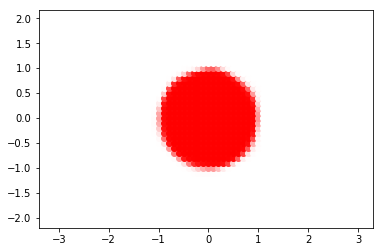

In [8]:
filename = "smart_duckling_grid_and_bounds.h5"
if(not os.path.isfile(filename)):
    teach_model(np.append(grid,bounding,axis=0),10000,filename)
plot_from_model(filename,smooth=True)

Вот это - уже приличный результат.